<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/pytorch_RPCA_with_prox_backward_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla T4
0
0


# L1 and nuclear loss functions with backward by prox (soft thresholding and singular value thresholding)

In [0]:
soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import zipfile
import os
zip_filename = '/content/drive/My Drive/share/data/hall.zip'
zip_ref = zipfile.ZipFile(zip_filename, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

root_dir = "/tmp"
imageseq_files = os.listdir(root_dir)


from PIL import Image
import numpy as np

im = np.array(Image.open(root_dir + '/' + imageseq_files[0]))


#imageseq = np.ndarray((len(imageseq_files), im.shape[0], im.shape[1], im.shape[2]), dtype=np.uint8)
imageseq = []
for filename in imageseq_files:
    fullname = root_dir + '/' + filename
    if os.path.isfile(fullname):
        imageseq.append(np.array(Image.open(fullname).convert('L')))

imageseq = np.array(imageseq)
print(imageseq.shape)

(3584, 144, 176)


In [6]:
frames_begin, frames_end = 0, 50
nframes = frames_end - frames_begin
DDseq = imageseq[frames_begin:frames_end,:,:].copy().astype(float) / 255.
DDseq_t = imageseq[-nframes:,:,:].copy().astype(float) / 255.

DD = DDseq.reshape(nframes,imageseq.shape[1]*imageseq.shape[2]).T
DD_t = DDseq_t.reshape(nframes,imageseq.shape[1]*imageseq.shape[2]).T
#DD = imageseq[frames_begin:frames_end,:,:].reshape(nframes,imageseq.shape[1]*imageseq.shape[2]).T
#DD = DD.astype(float) / 255

print(DD.shape)
print(DD.min(), DD.max())

m, n = imageseq.shape[1:]
ls = 1./np.sqrt(max(m,n)) / 16
print('lambda_S = ', ls)
ln = 1.

(25344, 50)
0.0 1.0
lambda_S =  0.004711114759027557


In [7]:
#https://qiita.com/MuAuan/items/acee29099a98c5cfb020
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

def anim_make(MM, hw, vmin=0, vmax=1,interval=200):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[1]):
        V = []
        for l in range(len(MM)):
            V.append(MM[l][:,i].reshape(hw))
        #ims.append( [plt.imshow(np.abs(M[:,i]).reshape(hw), cmap='gray', vmin=vmin, vmax=vmax)] )
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

Danim = anim_make([DD], imageseq.shape[1:])
HTML(Danim.to_html5_video())


# Robust PCA (Low-rank and sparse matrix approximation): $$\textrm{Minimize}_{(L,S)}\|L\|_* + \lambda_S \|S\|_1+\lambda_F\|D-(L+S)\|_F^2$$
### Auto differentiation vs. proximal operation



In [0]:
from time import time
class dummyUnet(torch.nn.Module):
    def __init__(self, w=torch.tensor(1.0, device=device)):
        super(dummyUnet, self).__init__()
        self.param = torch.nn.Parameter(w, requires_grad=True)

    def forward(self, inputD):  # compute the output only from inputD!
        return self.param

## ADMM-type (Inexact ALM) application of backward by prox
### less estimation error, can clearly identify the sparse components

D = 
 tensor([[0.0706, 0.1020, 0.0667,  ..., 0.0667, 0.1294, 0.0863],
        [0.4549, 0.4549, 0.3843,  ..., 0.4235, 0.4745, 0.4745],
        [0.4431, 0.4157, 0.4314,  ..., 0.4275, 0.4667, 0.4627],
        ...,
        [0.0784, 0.0275, 0.0353,  ..., 0.0667, 0.0745, 0.0549],
        [0.0627, 0.0235, 0.0196,  ..., 0.0353, 0.0353, 0.0471],
        [0.0431, 0.0039, 0.0314,  ..., 0.0353, 0.0431, 0.0392]],
       device='cuda:0')
lambda_F =  1000000.0
[ 40/400]: loss = 895.7920,  
[ 80/400]: loss = 886.4265,  
[120/400]: loss = 885.6236,  
[160/400]: loss = 885.4362,  
[200/400]: loss = 885.3704,  
[240/400]: loss = 885.3425,  
[280/400]: loss = 885.3281,  
[320/400]: loss = 885.3188,  
[360/400]: loss = 885.3120,  
[400/400]: loss = 885.3069,  
25457.28826522827  [ms]
Estimated L = 
 tensor([[0.0760, 0.0890, 0.0842,  ..., 0.0826, 0.0918, 0.0910],
        [0.4400, 0.4444, 0.4390,  ..., 0.4428, 0.4530, 0.4620],
        [0.4402, 0.4360, 0.4314,  ..., 0.4407, 0.4453, 0.4627],
        ...,
     

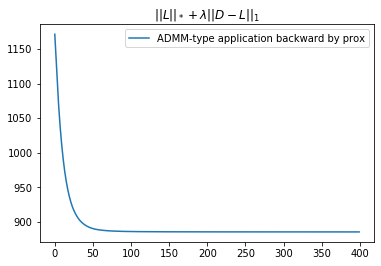

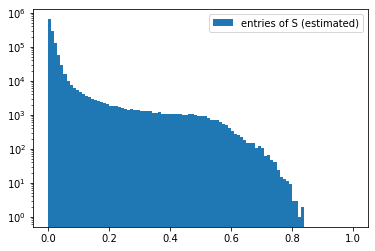

In [9]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

le = 1e+6
print('lambda_F = ', le)

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ls))
l2loss = lambda x: torch.sum(x**2)

L = 0
S = 0
E = 0
Y = 0

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss_inexact = []
for iter in range(num_iter):
    total_loss = 0.

    X = (D-S-E+Y).clone().detach().requires_grad_(True)
    loss = nucloss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    L = X.detach()

    X = (D-L-E+Y).clone().detach().requires_grad_(True)
    loss = l1loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    S = X.detach()

    X = ((D-L-S+Y)/ (1+2*le)).clone().detach().requires_grad_(True)
    loss = l2loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    E = X.detach()

    Y = Y + (D-L-S-E)

    total_loss = nucloss(L) + l1loss(D-L)

    history_loss_inexact.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')
print('Estimated L = \n', L.data)
print('Its singular values = \n', torch.svd(L)[1])
print('(L-D)/D: ', np.linalg.norm(DD-L.cpu().data.numpy())/np.linalg.norm(DD)*100, ' [%]')
print('Estimated S = \n', S.data)

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.legend()

DLSanim = anim_make([DD,L.cpu().data.numpy(),S.cpu().data.numpy()], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())
#Sanim = anim_make(S.cpu().data.numpy(), imageseq.shape[1:])
#HTML(Sanim.to_html5_video())

## ISTA with backward by prox
$$ L^{(k+1)}\gets\textrm{SVT}(L^{(k)}+\alpha(D-L^{(k)}-S^{(k)}),\alpha\lambda_L)$$
$$ S^{(k+1)}\gets\textrm{soft}(S^{(k)}+\alpha(D-L^{(k)}-S^{(k)}),\alpha\lambda_S)$$


D = 
 tensor([[0.0706, 0.1020, 0.0667,  ..., 0.0667, 0.1294, 0.0863],
        [0.4549, 0.4549, 0.3843,  ..., 0.4235, 0.4745, 0.4745],
        [0.4431, 0.4157, 0.4314,  ..., 0.4275, 0.4667, 0.4627],
        ...,
        [0.0784, 0.0275, 0.0353,  ..., 0.0667, 0.0745, 0.0549],
        [0.0627, 0.0235, 0.0196,  ..., 0.0353, 0.0353, 0.0471],
        [0.0431, 0.0039, 0.0314,  ..., 0.0353, 0.0431, 0.0392]],
       device='cuda:0')
[ 80/800]: loss = 928.8721,  
[160/800]: loss = 919.0029,  
[240/800]: loss = 918.1478,  
[320/800]: loss = 917.9446,  
[400/800]: loss = 917.8755,  
[480/800]: loss = 917.8483,  
[560/800]: loss = 917.8332,  
[640/800]: loss = 917.8242,  
[720/800]: loss = 917.8177,  
[800/800]: loss = 917.8126,  
26314.86439704895  [ms]
Estimated L = 
 tensor([[0.0782, 0.0869, 0.0839,  ..., 0.0834, 0.0894, 0.0905],
        [0.4416, 0.4443, 0.4414,  ..., 0.4423, 0.4528, 0.4621],
        [0.4403, 0.4356, 0.4333,  ..., 0.4409, 0.4450, 0.4611],
        ...,
        [0.0360, 0.0387, 0.

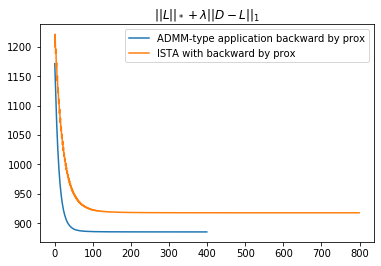

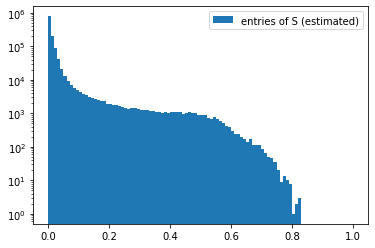

In [10]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

ln = 1.
alpha = 1.
# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(alpha*ln))
l1loss = L1Loss(lw=torch.tensor(alpha*ls))
#X = torch.autograd.Variable(D, requires_grad=True)
L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
S = torch.zeros_like(L, device=device, requires_grad=True)
#optimizer = torch.optim.SGD([L,S], lr = 1e0)

t = time()
num_iter = 800
display_step = num_iter // 10
history_loss_prox = []
for iter in range(num_iter):
    total_loss = 0.

    # E = (L + S + alpha * R.T.dot(D - R.dot(L + S))).detach()
    E = (L + S + alpha * (D - L - S)).detach()

    Lk = L.detach()
    L = (E-S).clone().detach().requires_grad_(True)
    loss = nucloss(L)
    optimizer = torch.optim.SGD([L], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()/alpha

    S = (E-Lk).clone().detach().requires_grad_(True)
    loss = l1loss(S)
    optimizer = torch.optim.SGD([S], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()/alpha
    #"""

    history_loss_prox.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('Estimated L = \n',L.data)
print('Its singular values = \n', torch.svd(L)[1])
print('(L-D)/D: ', np.linalg.norm(DD-L.cpu().data.numpy())/np.linalg.norm(DD)*100, ' [%]')
print('Estimated S = \n', S.data)

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA with backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.legend()
DLSanim = anim_make([DD,L.cpu().data.numpy(),S.cpu().data.numpy()], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())

### Best practice: Adam followed by SGD

D = 
 tensor([[0.0706, 0.1020, 0.0667,  ..., 0.0667, 0.1294, 0.0863],
        [0.4549, 0.4549, 0.3843,  ..., 0.4235, 0.4745, 0.4745],
        [0.4431, 0.4157, 0.4314,  ..., 0.4275, 0.4667, 0.4627],
        ...,
        [0.0784, 0.0275, 0.0353,  ..., 0.0667, 0.0745, 0.0549],
        [0.0627, 0.0235, 0.0196,  ..., 0.0353, 0.0353, 0.0471],
        [0.0431, 0.0039, 0.0314,  ..., 0.0353, 0.0431, 0.0392]],
       device='cuda:0')
[ 10/100]: loss = 1203.9243,  
[ 20/100]: loss = 1029.2843,  
[ 30/100]: loss = 971.0458,  
[ 40/100]: loss = 945.8478,  
[ 50/100]: loss = 934.6023,  
[ 60/100]: loss = 929.3847,  
[ 70/100]: loss = 926.7072,  
[ 80/100]: loss = 925.1580,  
[ 90/100]: loss = 924.1760,  
[100/100]: loss = 923.6978,  
[ 60/600]: loss = 895.9198,  
[120/600]: loss = 895.8976,  
[180/600]: loss = 895.8933,  
[240/600]: loss = 895.8918,  
[300/600]: loss = 895.8909,  
[360/600]: loss = 895.8904,  
[420/600]: loss = 895.8901,  
[480/600]: loss = 895.8900,  
[540/600]: loss = 895.8900,  


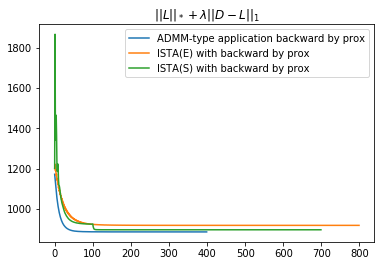

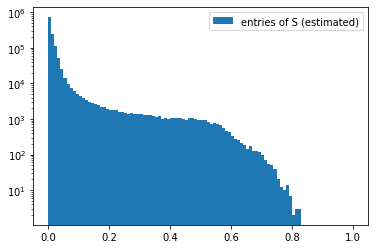

In [11]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

#model = dummyUnet()
model = dummyUnet(w=torch.zeros_like(D, device=device, requires_grad=True))
optimizerM = torch.optim.Adam(model.parameters(), lr = 1e-1)

lr = 1e0
ln = 1.
alpha = 0.5
# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(alpha*ln / lr))
l1loss = L1Loss(lw=torch.tensor(alpha*ls / lr))

anucloss = lambda x: torch.sum(torch.svd(x)[1])*alpha*ln
al1loss = lambda x: torch.sum(torch.abs(x)*alpha*ls)

#X = torch.autograd.Variable(D, requires_grad=True)
#S = torch.zeros_like(D, device=device, requires_grad=True)
S = model(D)


t = time()
num_iter = 100
display_step = num_iter // 10
history_loss_prox_ISTA = []
#optimizer = torch.optim.Adam([S], lr = 1e0)
for iter in range(num_iter):

    total_loss = 0.
    loss = anucloss(D-S) + al1loss(S)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    history_loss_prox_ISTA.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


num_iter = 600
display_step = num_iter // 10
#history_loss_prox_ISTA = []
#L = D.clone().detach()
#optimizer = torch.optim.SGD([S], lr = 1e0)
optimizerM = torch.optim.SGD(model.parameters(), lr = lr)
for iter in range(num_iter):

    total_loss = 0.
    #Lk = L.detach()
    with torch.no_grad():
        Sk = model(D).detach()
    Lk = (D-Sk).detach()
    S = model(D)
    #L = Lk + alpha * (D - Lk -S)
    #L = Lk + alpha * (Sk - S)
    #loss = nucloss(L)
    loss = nucloss(Lk + alpha * (Sk - S))
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha * lr

    #St = S + alpha * (D - Lk - S)
    #loss = l1loss(St)
    #loss = l1loss(S + alpha * (D - Lk - S))
    loss = l1loss(S + alpha * (Sk - S))           # good
    #loss = l1loss(S)                              # excellent if not noisy
    #optimizerM = torch.optim.SGD(model.parameters(), lr = 5e-1)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha * lr
    #"""

    #total_loss = (anucloss(Lk) + al1loss(S)) / alpha * lr  # compute loss precisely
    history_loss_prox_ISTA.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')
print('Estimated L = \n',Lk.data)
print('Its singular values = \n', torch.svd(Lk)[1])
#S = D-L
print('Estimated S = \n', S.data)

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.legend()

from skimage import filters
SS = S.cpu().data.numpy()
SS = np.abs(SS)
th = filters.threshold_otsu(SS)
print(th*255, np.median(SS.ravel())*255)
if th < np.median(SS.ravel())*2: th = np.inf
SS[SS < th] = 0.
SS[SS >= th]= 1.
DLSanim = anim_make([DD,Lk.cpu().data.numpy(),S.cpu().data.numpy(), SS], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())

## RPCA with alternating gradient descent using autograd
### cannot sparsify the solution due to the nondifferentiability (see the estimated S), although decrease the loss faster

D = 
 tensor([[0.0706, 0.1020, 0.0667,  ..., 0.0667, 0.1294, 0.0863],
        [0.4549, 0.4549, 0.3843,  ..., 0.4235, 0.4745, 0.4745],
        [0.4431, 0.4157, 0.4314,  ..., 0.4275, 0.4667, 0.4627],
        ...,
        [0.0784, 0.0275, 0.0353,  ..., 0.0667, 0.0745, 0.0549],
        [0.0627, 0.0235, 0.0196,  ..., 0.0353, 0.0353, 0.0471],
        [0.0431, 0.0039, 0.0314,  ..., 0.0353, 0.0431, 0.0392]],
       device='cuda:0')
[ 40/400]: loss = 965.4825,  
[ 80/400]: loss = 958.1157,  
[120/400]: loss = 956.5130,  
[160/400]: loss = 955.9186,  
[200/400]: loss = 955.6931,  
[240/400]: loss = 955.5358,  
[280/400]: loss = 955.4787,  
[320/400]: loss = 955.5008,  
[360/400]: loss = 955.4215,  
[400/400]: loss = 955.4599,  
13123.06547164917  [ms]
Estimated L = 
 tensor([[0.0715, 0.0950, 0.0717,  ..., 0.0677, 0.0923, 0.0868],
        [0.4493, 0.4423, 0.4367,  ..., 0.4334, 0.4501, 0.4704],
        [0.4490, 0.4234, 0.4343,  ..., 0.4392, 0.4526, 0.4749],
        ...,
        [0.0463, 0.0288, 0.

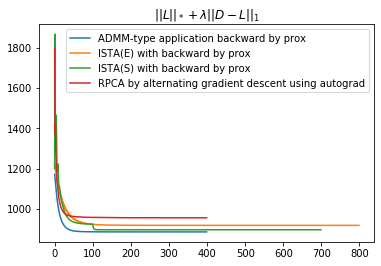

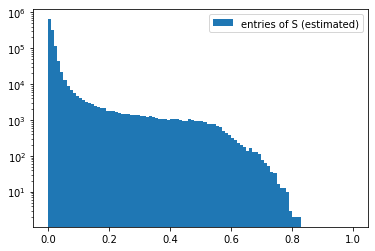

In [12]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ls)

#L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
#optimizer = torch.optim.Adam([L], lr = 1e-1)
S = torch.zeros_like(D, device=device, requires_grad=True)
optimizer = torch.optim.Adam([S], lr = 1e-1)

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    """
    loss = nucloss(L) + l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    #loss = nucloss(L)
    loss = nucloss(D-S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    #loss = l1loss(D-L)
    loss = l1loss(S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    #"""

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
L = D-S
print('Estimated L = \n', L.data)
print('Its singular values = \n', torch.svd(L)[1])
#S = D-L
print('Estimated S = \n', S.data)

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.plot(history_loss, label="RPCA by alternating gradient descent using autograd")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.legend()

from skimage import filters
SS = S.cpu().data.numpy()
SS = np.abs(SS)
th = filters.threshold_otsu(SS)
print(th*255, np.median(SS.ravel())*255)
if th < np.median(SS.ravel())*2: th = np.inf
SS[SS < th] = 0.
SS[SS >= th]= 1.
DLSanim = anim_make([DD,Lk.cpu().data.numpy(),S.cpu().data.numpy(), SS], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())
#DLSanim = anim_make([DD,L.cpu().data.numpy(),S.cpu().data.numpy()], (imageseq.shape[1],imageseq.shape[2]))
#HTML(DLSanim.to_html5_video())

## RPCA by gradient descent using autograd
### straightforward use of autograd for RPCA cannot sparsify the solution (see the estimated S).

D = 
 tensor([[0.0706, 0.1020, 0.0667,  ..., 0.0667, 0.1294, 0.0863],
        [0.4549, 0.4549, 0.3843,  ..., 0.4235, 0.4745, 0.4745],
        [0.4431, 0.4157, 0.4314,  ..., 0.4275, 0.4667, 0.4627],
        ...,
        [0.0784, 0.0275, 0.0353,  ..., 0.0667, 0.0745, 0.0549],
        [0.0627, 0.0235, 0.0196,  ..., 0.0353, 0.0353, 0.0471],
        [0.0431, 0.0039, 0.0314,  ..., 0.0353, 0.0431, 0.0392]],
       device='cuda:0')
[100/1000]: loss = 1103.2542,  
[200/1000]: loss = 1028.3835,  
[300/1000]: loss = 972.5282,  
[400/1000]: loss = 932.7104,  
[500/1000]: loss = 907.8326,  
[600/1000]: loss = 896.4470,  
[700/1000]: loss = 893.0046,  
[800/1000]: loss = 892.1106,  
[900/1000]: loss = 891.8587,  
[1000/1000]: loss = 891.7365,  
30693.310499191284  [ms]
Estimated L = 
 tensor([[0.0706, 0.0897, 0.0827,  ..., 0.0787, 0.0934, 0.0903],
        [0.4389, 0.4450, 0.4383,  ..., 0.4413, 0.4565, 0.4665],
        [0.4431, 0.4377, 0.4314,  ..., 0.4394, 0.4467, 0.4627],
        ...,
        [0.04

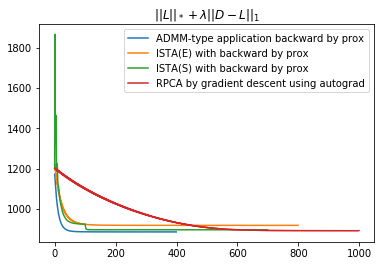

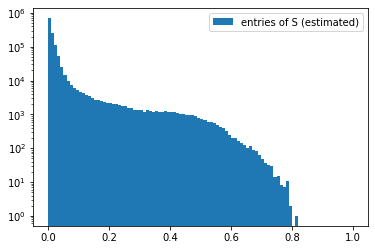

In [13]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

le = 1e+6

# Using sum of abs with autogradient
nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ls)
l2loss = lambda x: torch.sum(x**2)

L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
S = torch.zeros_like(D, device=device, requires_grad=True)

t = time()
num_iter = 1000
display_step = num_iter // 10
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    #"""
    #optimizer = torch.optim.SGD([L,S], lr = 1e0)
    #loss = nucloss(L) + l1loss(S) + l2loss((D-L-S)/(1+2*le))

    #optimizer = torch.optim.SGD([L], lr = 1e0)   # SGD works better than Adam
    #optimizer = torch.optim.AdamW([L], lr = 0.3)  # Adam would disappoint you
    #loss = nucloss(L) + l1loss(D-L)

    #optimizer = torch.optim.SGD([S], lr = 1e0)   # SGD works better than Adam
    optimizer = torch.optim.Adam([S], lr = 1e-3)  # Adam would disappoint you
    loss = nucloss(D-S) + l1loss(S)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    optimizer = torch.optim.SGD([L], lr = 1e-1)
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([S], lr = 1e-1)
    loss = l1loss(S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([L,S], lr = 1e-1)
    loss = l2loss(D-L-S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

#S = D-L
L = D-S

print((time()-t)*1000, ' [ms]')
print('Estimated L = \n', L.data)
print('Its singular values = \n', torch.svd(L)[1])
print('Estimated S = \n', S.data)

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.plot(history_loss, label="RPCA by gradient descent using autograd")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.legend()

from skimage import filters
SS = S.cpu().data.numpy()
SS = np.abs(SS)
th = filters.threshold_otsu(SS)
print(th*255, np.median(SS.ravel())*255)
if th < np.median(SS.ravel())*2: th = np.inf
SS[SS < th] = 0.
SS[SS >= th]= 1.
DLSanim = anim_make([DD,Lk.cpu().data.numpy(),S.cpu().data.numpy(), SS], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())
#LSanim = anim_make(np.vstack((L.cpu().data.numpy(),S.cpu().data.numpy())), (imageseq.shape[1]*2,imageseq.shape[2]))
#HTML(LSanim.to_html5_video())

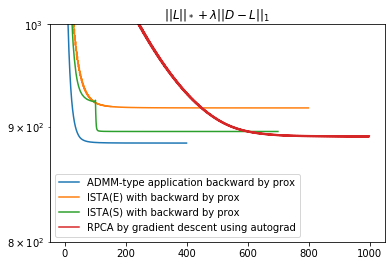

In [17]:
import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.plot(history_loss, label="RPCA by gradient descent using autograd")
plt.yscale('log'); plt.ylim(8e+2,1e+3)
plt.legend()


In [0]:
class UNet(torch.nn.Module):

    def __init__(self, in_channels, encoder_channels, decoder_channels):
        super().__init__()
        def TripleConvs(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3,padding=1),
                torch.nn.BatchNorm3d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(out_channels, out_channels, 3,padding=1),
                torch.nn.BatchNorm3d(out_channels),
                torch.nn.ReLU(inplace=True)
            )   
        def last_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv3d(in_channels, out_channels, 3,padding=1)
            )   

        self.convs1 = double_conv(in_channels,out_channels1)
        self.convs2 = double_conv(out_channels1,out_channels2)      
        self.upsample1_S = torch.nn.Upsample(scale_factor=2,mode = 'bilinear')      
        self.upsample2_S = torch.nn.Upsample(scale_factor=2,mode = 'bilinear')
        self.downsample1 = torch.nn.AvgPool2d(2)
        self.downsample2 = torch.nn.AvgPool2d(2)
        self.dconvs1_S = double_conv(out_channels2_S + out_channels1,out_channels1_S)
        self.last_S = last_conv(out_channels1_S,in_channels)

    def forward(self, x):
        def shape_4d(d):#downsample,upsampleは3次元ではなく2次元でおこなうため、shapeを(B:バッチ,C:チャンネル数,D:時系列,H:高さ,W:横幅)から(B*D,C,H,W)の形状へ変換
          SH = d.shape
          sha1 = SH[0]
          d = d.view(SH[0]*SH[2],SH[1],SH[3],SH[4])#(B,C,H,W)
          #print(d.shape)
          return d,sha1

        def shape_5d(d,sha1):#downsample,upsample終了後、(B*D,C,H,W)から(B,C,D,H,W)へ変換
          sh = d.shape
          d = d.view(sha1,sh[1],sh[0],sh[2],sh[3])
          #print(d.shape)
          return d

        #down
        convs1 = self.convs1(x)  #x:(B,C,D,H,W)
        x,sh1 = shape_4d(convs1) #x:(B*D,C,H,W) 
        x = self.downsample1(x)  #x:(B*D,C,H,W)
        x = shape_5d(x,sh1)      #x:(B,C,D,H,W)
        x = self.convs2(x)       #x:(B,C,D,H,W)

        #up
        s,sh1 = shape_4d(x)      #s:(B*D,C,H,W)
        s = self.upsample1_S(s)  #s:(B*D,C,H,W)
        s = shape_5d(s,sh1)      #s:(B,C,D,H,W)
        s = torch.cat([s, convs1], dim=1) #copy and crop
        s = self.dconvs1_S(s)    #s:(B,C,D,H,W)
        out_S = self.last_S(s)   #s:(B,C,D,H,W),out_S:(B,C,D,H,W)

        return out_S
    

In [0]:
class UNet(torch.nn.Module):

    def __init__(self, in_channels,out_channels1,out_channels2,out_channels2_S,out_channels1_S):
        super().__init__()
        def double_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv3d(in_channels, out_channels, 3,padding=1),
                torch.nn.BatchNorm3d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(out_channels, out_channels, 3,padding=1),
                torch.nn.BatchNorm3d(out_channels),
                torch.nn.ReLU(inplace=True)
            )   
        def last_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv3d(in_channels, out_channels, 1, padding=0)
            )
        def upsample(in_channels, out_channels, scale_factor, mode):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=scale_factor, mode=mode),
                torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
            )
        
        self.convs1 = double_conv(in_channels,out_channels1)
        self.downsample1 = torch.nn.AvgPool2d(2)
        self.convs2 = double_conv(out_channels1,out_channels2)
        self.upsample1_S = upsample(out_channels2, out_channels2, 2, 'bilinear') #torch.nn.Upsample(scale_factor=2,mode = 'bilinear')      
        #self.upsample2_S = torch.nn.Upsample(scale_factor=2,mode = 'bilinear')
        self.downsample2 = torch.nn.AvgPool2d(2)
        self.dconvs1_S = double_conv(out_channels2_S + out_channels1,out_channels1_S)
        self.last_S = last_conv(out_channels1_S,in_channels)

    def forward(self, x):
        def shape_4d(d):#downsample,upsampleは3次元ではなく2次元でおこなうため、shapeを(B:バッチ,C:チャンネル数,D:時系列,H:高さ,W:横幅)から(B*D,C,H,W)の形状へ変換
          SH = d.shape
          sha1 = SH[0]
          d = d.view(SH[0]*SH[2],SH[1],SH[3],SH[4])#(B,C,H,W)
          #print(d.shape)
          return d,sha1

        def shape_5d(d,sha1):#downsample,upsample終了後、(B*D,C,H,W)から(B,C,D,H,W)へ変換
          sh = d.shape
          d = d.view(sha1,sh[1],sh[0],sh[2],sh[3])
          #print(d.shape)
          return d

        #encoding
        convs1 = self.convs1(x)  #x:(B,C,D,H,W)
        x,sh1 = shape_4d(convs1) #x:(B*D,C,H,W) 
        x = self.downsample1(x)  #x:(B*D,C,H,W)
        x = shape_5d(x,sh1)      #x:(B,C,D,H,W)
        x = self.convs2(x)       #x:(B,C,D,H,W)

        #decoding
        s,sh1 = shape_4d(x)      #s:(B*D,C,H,W)
        s = self.upsample1_S(s)  #s:(B*D,C,H,W)
        s = shape_5d(s,sh1)      #s:(B,C,D,H,W)
        s = torch.cat([s, convs1], dim=1) #copy and crop
        s = self.dconvs1_S(s)    #s:(B,C,D,H,W)
        out_S = self.last_S(s)   #s:(B,C,D,H,W),out_S:(B,C,D,H,W)

        return out_S
    

In [142]:
ln = 1.
alpha = 0.5
# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(alpha*ln))
l1loss = L1Loss(lw=torch.tensor(alpha*ls))

anucloss = lambda x: torch.sum(torch.svd(x)[1])*alpha*ln
al1loss = lambda x: torch.sum(torch.abs(x)*alpha*ls)

D = torch.from_numpy(DD.astype(np.float32)).to(device)
print(D.shape)

torch.Size([25344, 50])


In [146]:
modelUnet = UNet(1,16,32,32,64).to(device)

wc = 1e-2
def init_weight(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.constant_(m.weight, wc)
        #torch.nn.init.uniform_(m.weight)

    # use the modules apply function to recursively apply the initialization
#modelUnet.apply(init_weight)


as_imgseq = (1, 1) +  DDseq.shape
print(as_imgseq)
model = lambda x: modelUnet(x.T.view(as_imgseq)).view(DDseq.shape[0],-1).T
S = model(D)
print(S.shape)

(1, 1, 50, 144, 176)
torch.Size([25344, 50])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[  1/2]: loss = 1298.0033,  
[  2/2]: loss = 1298.0033,  


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[ 20/1000]: loss = 1268.7819,  
[ 40/1000]: loss = 1245.9471,  
[ 60/1000]: loss = 1227.6033,  
[ 80/1000]: loss = 1212.5663,  
[100/1000]: loss = 1199.9903,  
[120/1000]: loss = 1189.3033,  
[140/1000]: loss = 1180.1004,  
[160/1000]: loss = 1172.1016,  
[180/1000]: loss = 1165.0432,  
[200/1000]: loss = 1158.8003,  
[220/1000]: loss = 1153.2255,  
[240/1000]: loss = 1148.2003,  
[260/1000]: loss = 1143.6522,  
[280/1000]: loss = 1139.5081,  
[300/1000]: loss = 1135.6883,  
[320/1000]: loss = 1132.1823,  
[340/1000]: loss = 1128.9417,  
[360/1000]: loss = 1125.9331,  
[380/1000]: loss = 1123.1090,  
[400/1000]: loss = 1120.4803,  
[420/1000]: loss = 1118.0177,  
[440/1000]: loss = 1115.7023,  
[460/1000]: loss = 1113.5155,  
[480/1000]: loss = 1111.4535,  
[500/1000]: loss = 1109.5027,  
[520/1000]: loss = 1107.6612,  
[540/1000]: loss = 1105.8939,  
[560/1000]: loss = 1104.2225,  
[580/1000]: loss = 1102.6426,  
[600/1000]: loss = 1101.1228,  
[620/1000]: loss = 1099.6685,  
[640/100

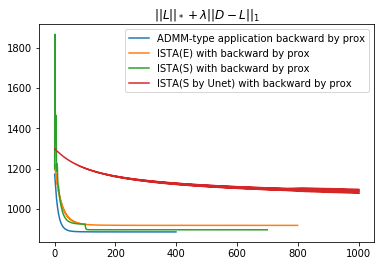

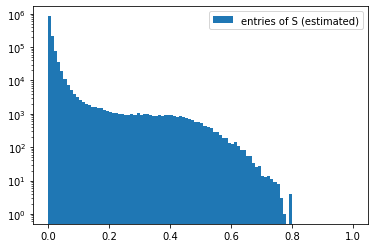

In [171]:
lr = {'Adam': 3e-6, 'SGD': 3e-6}      #learning rate

save_net = True
t = time()
num_iter = 2
display_step = num_iter // 2
history_loss_Unet = []

optimizerM = torch.optim.Adam(modelUnet.parameters(),lr=lr['Adam'])
for iter in range(num_iter):

    total_loss = 0.
    loss = anucloss(D-S) + al1loss(S)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    history_loss_Unet.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


num_iter = 1000
display_step = num_iter // 50
#history_loss_prox_ISTA = []
#L = D.clone().detach()
#optimizer = torch.optim.SGD([S], lr = 1e0)
optimizerM = torch.optim.SGD(modelUnet.parameters(), lr = lr['SGD'])
for iter in range(num_iter):

    total_loss = 0.
    #Lk = L.detach()
    with torch.no_grad():
        Sk = model(D).detach()
    Lk = (D-Sk).detach()
    S = model(D)
    #L = Lk + alpha * (D - Lk -S)
    #L = Lk + alpha * (Sk - S)
    #loss = nucloss(L)
    loss = nucloss(Lk + alpha * (Sk - S))
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    #St = S + alpha * (D - Lk - S)
    #loss = l1loss(St)
    #loss = l1loss(S + alpha * (D - Lk - S))
    loss = l1loss(S + alpha * (Sk - S))           # good
    #loss = l1loss(S)                              # excellent if not noisy
    #optimizerM = torch.optim.SGD(model.parameters(), lr = 5e-1)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha
    #"""

    #total_loss = (anucloss(Lk) + al1loss(S)) / alpha * lr  # compute loss precisely
    history_loss_Unet.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')
print('Estimated L = \n',Lk.data)
print('Its singular values = \n', torch.svd(Lk)[1])
#S = D-L
print('Estimated S = \n', S.data)

if save_net:
    from time import time, strftime
    modelname = "RPCA_Unet_hall_" + strftime("%Y%m%d-%H%M%S")
    import cloudpickle
    model_path = '/content/drive/My Drive/share/data/temp/'
    with open(model_path + modelname + '.pkl', 'wb') as f:
        cloudpickle.dump(modelUnet, f)


import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.plot(history_loss_Unet, label="ISTA(S by Unet) with backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.legend()

from skimage import filters
SS = S.cpu().data.numpy()
SS = np.abs(SS)
th = filters.threshold_otsu(SS)
print(th*255, np.median(SS.ravel())*255)
if th < np.median(SS.ravel())*2: th = np.inf
SS[SS < th] = 0.
SS[SS >= th]= 1.
DLSanim = anim_make([DD,Lk.cpu().data.numpy(),S.cpu().data.numpy(), SS], (imageseq.shape[1],imageseq.shape[2]))
#DLSanim = anim_make([DD,Lk.cpu().data.numpy(),S.cpu().data.numpy(), Lk.cpu().data.numpy()+S.cpu().data.numpy()], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())

In [170]:
with open(model_path + modelname + '.pkl', 'rb') as f:
    modelUnet = cloudpickle.load(f)

model = lambda x: modelUnet(x.T.view(as_imgseq)).view(DDseq.shape[0],-1).T
S = model(D)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [159]:
print(modelUnet)

UNet(
  (convs1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (downsample1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (convs2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (upsample1_S): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bi

In [1]:
D_t = torch.from_numpy(DD_t.astype(np.float32)).to(device)
with torch.no_grad():
    S_t = model(D_t)

from skimage import filters
SS = S_t.cpu().data.numpy()
SS = np.abs(SS)
th = filters.threshold_otsu(SS)
print(th*255, np.median(SS.ravel())*255)
if th < np.median(SS.ravel())*2: th = np.inf
SS[SS < th] = 0.
SS[SS >= th]= 1.
DLSanim = anim_make([DD_t,DD_t-S_t.cpu().data.numpy(),S_t.cpu().data.numpy(), SS], (imageseq.shape[1],imageseq.shape[2]))
#DLSanim = anim_make([DD,Lk.cpu().data.numpy(),S.cpu().data.numpy(), Lk.cpu().data.numpy()+S.cpu().data.numpy()], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())

NameError: ignored